In [1]:
import capnp
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

capnp.remove_import_hook()
interface_capnp = capnp.load("../../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/704ed70d4fd1c6bd6342c436f1ede30d1cff4710


# Generate event log

In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [3]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < dataGenerationModel.json > /tmp/dataGenerationModel.bin
with open("/tmp/dataGenerationModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light1 = red THEN light2 IN {red}
IF light2 = green THEN output IN [0.000000, 10.000000]
IF light2 = yellow THEN DELTA output IN [12.000000, 15.000000]
IF light1 = green THEN num = 42.000000
IF light1: red -> yellow THEN num = num_prev * 0.900000
IF light2: yellow -> red THEN output = output_prev - 7.000000



In [4]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [5]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "output",\n  differenceRule = (co...        239
1  ( variable = "num",\n  factorRule = (constant ...        198
2  ( variable = "light2",\n  valueSetRule = (set ...        642
3  ( variable = "output",\n  changeRangeRule = (m...        453
4  ( variable = "num",\n  valueRule = (constant =...        673
5  ( variable = "output",\n  valueRangeRule = (mi...        434

# Score development

In [6]:
from scoredevelopment import visualizeScoreDevelopment

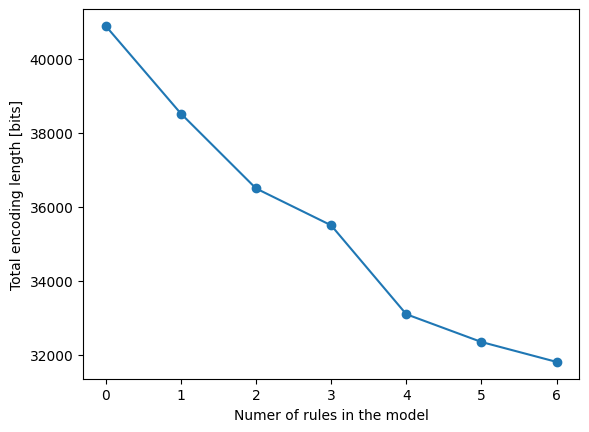

In [7]:
visualizeScoreDevelopment("dataGenerationModel", resolvedEventLogPromise.log, interface_capnp)

# Debug event log generation

Why do we get event logs where categorical variables always have the same value?

In [2]:
import sys
sys.path.append("../../..")
from experiments.modelgeneration import ModelGenerator
from experiments.dataframetocapnp import dataframeFromMessage

In [3]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [4]:
modelGen = ModelGenerator(interface_capnp, processDataUpdates, None)

In [5]:
def findErrorCase():
    modelCount = 0
    while True:
        modelCount += 1
        model = modelGen.generateTrueModels(numberOfModels=1, numberOfRules=5, catVariablesCount=2, 
                                            numVariablesCount=2, valuesPerCatVariable=4,
                                            targetType="categorical")[0]
        log = processDataUpdates.generateEventLog(model, 50, 10).wait().log
        logFrame = dataframeFromMessage(log, disableProgressBar=True)
        for column in logFrame.columns:
            if len(logFrame[column].unique()) == 1:
                print("Variable", column, "only has one value", logFrame[column][0])
                print("Model", modelCount, ":")
                print(processDataUpdates.modelToString(model).wait().string)
                return model, logFrame

In [ ]:
model, logFrame = findErrorCase()